# Building a prediction model using feature engineered columns and Logistic Regression (more interpretability)

This model is the ideal version as it would bring more interpretability to the predictive power of our features.

## Imports - Logistic Regression, TTS, StandardScaler, Classification Report, Confusion Matrix, Accuracy Score

In [21]:
# import manual_run_prem
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

df = pd.read_csv('/Users/thomasdoherty/Desktop/football-project/football-project-mvp/manual_run_prem_v2.5.csv')

In [23]:
df.tail()

,date,ppg_season_diff,net_goals_diff,home_pts_last_5,away_pts_last_5,pts_last_5_diff,best_player_diff,p(Home),p(Draw),p(Away),Result
3035,2015-10-17,-0.38,-0.06,10,8,2,-2.5,0.457,0.258,0.285,0
3036,2015-10-19,0.13,0.14,5,7,-2,-1.5,0.457,0.258,0.285,-1
3037,2015-10-17,0.12,-0.24,11,5,6,-3.5,0.457,0.258,0.285,0
3038,2015-10-17,-0.75,-1.10,7,12,-5,-8.0,0.457,0.258,0.285,-1
3039,2015-10-17,0.62,-0.02,7,2,5,-1.0,0.457,0.258,0.285,1


## Logistic Regression

For V2.5, we are revisiting the data and running a logistic regression model with data split according to date (training on first 6 seasons, testing on last 2)

In [24]:
df['date'] = pd.to_datetime(df['date'])

training first 6 seasons and testing last 2 is 0.25 test/train split

In [25]:
# training data is all records before 2014-08-01
train = df[df['date'] < '2014-08-01']
# test data is all records after 2014-08-01
test = df[df['date'] >= '2014-08-01']

In [26]:
features = ['ppg_season_diff', 'net_goals_diff', 'pts_last_5_diff', 'best_player_diff', 'p(Home)', 'p(Draw)', 'p(Away)']  # List of all feature columns we proceed with
target = 'Result'

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

# Scale only the non-probability features in manual_run_prem. V2.5 we will scale all features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [28]:
# transform the test data
X_test_scaled = scaler.transform(X_test)

In [29]:
# Initialize Logistic Regression and RFE - weights if needed
#class_weights = {1: 2.0, 0: 1.4, -1: 1.5}

log_reg = LogisticRegression(random_state=42, class_weight=None, max_iter=1000)

In [30]:
# fit the model
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [31]:
# predictions on the test set
y_pred = log_reg.predict(X_test_scaled)

Classification Report:
              precision    recall  f1-score   support

          -1       0.49      0.49      0.49       231
           0       0.00      0.00      0.00       200
           1       0.50      0.81      0.62       329

    accuracy                           0.50       760
   macro avg       0.33      0.44      0.37       760
weighted avg       0.37      0.50      0.42       760

Accuracy: 0.5013157894736842


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


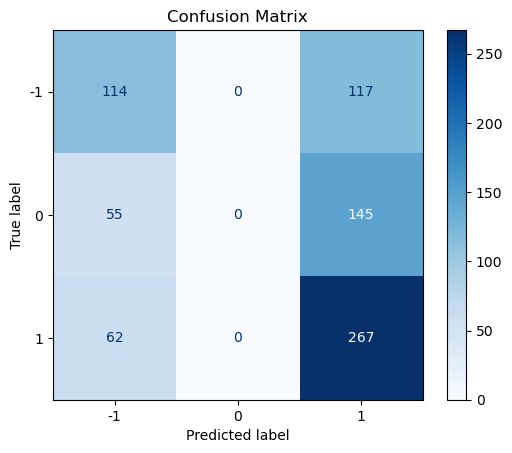

In [33]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print accuracy score
print("Accuracy:", accuracy_score(y_test, y_pred))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


V2.5 - Very comparable results to when we did not properly split for time-series, similar looking results:
- Hovering at 50% accuracy
- No proclivity to predict draws
- Big bias on home wins.

In [36]:
feature_importances = pd.DataFrame({
    'Feature': features,
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)
print(feature_importances)


            Feature  Coefficient
2   pts_last_5_diff     0.074806
4           p(Home)     0.000000
5           p(Draw)     0.000000
6           p(Away)     0.000000
3  best_player_diff    -0.041011
0   ppg_season_diff    -0.077414
1    net_goals_diff    -0.504259


The coefficients refer to the impact on the **positive class** here this is 1, or Home win. So understandably, stronger away teams (more negative goals_diff and ppg_season_diff) reduce probability of a home win

The prior probabilities need applying after the predictions

__________________________________

Old from V2 below (used RFE): 

Now we can try only the selected features from RFE - notice it's the Bayesian priors and two engineered features

In [341]:
# Step 5: Train Logistic Regression with Selected Features
X_selected = X[selected_features]  # Use only the priors, net goals diff and home_pts_last_5 per RFE results

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [342]:
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

In [343]:
# Evaluate performance
print("Logistic Regression with Selected Features:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Logistic Regression with Selected Features:
Accuracy: 0.5098684210526315
              precision    recall  f1-score   support

          -1       0.47      0.49      0.48       177
           0       0.00      0.00      0.00       152
           1       0.53      0.80      0.63       279

    accuracy                           0.51       608
   macro avg       0.33      0.43      0.37       608
weighted avg       0.38      0.51      0.43       608



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


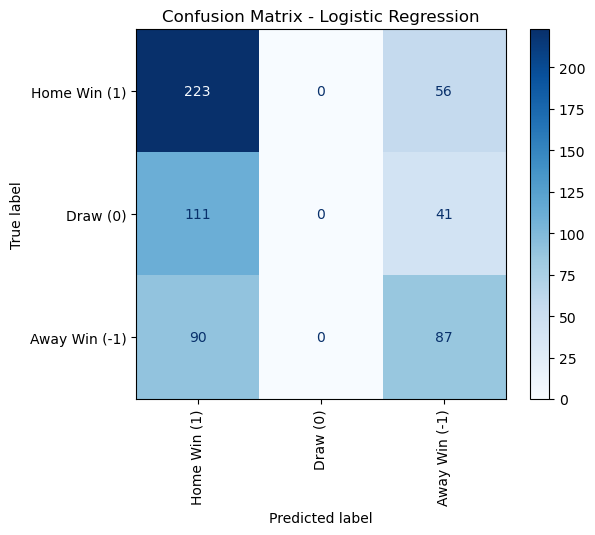

In [344]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[1, 0, -1])

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Home Win (1)', 'Draw (0)', 'Away Win (-1)'])

# Plot the confusion matrix
disp.plot(cmap='Blues', xticks_rotation='vertical')
disp.ax_.set_title("Confusion Matrix - Logistic Regression")
plt.show()

In [345]:
# print the results of the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[223   0  56]
 [111   0  41]
 [ 90   0  87]]


## Initial Analysis

V2:

Performance declined around 1% potentially due to overfitting. There may be redundancy in net goals_diff and points per game this season, and last_5_games

With RFE, it is showing that the Bayesian priors are the more influential statistics - with three features selected, net_goals_diff, p(home) and p(away) are selected.

I briefly played with manual/custom weights on the classes. Balanced class weights just removes lots of home wins and essentially guesses draws at the level of random chance, slightly deteriorating overall model performance.

I will try and scale the prior probabilities now too.

V1:

Performance of 51.9% means the correct result is predicteed just over half the time, better than chance (33%) and this performance is dominated by its correct prediction of home wins:
- recall score of 0.81 for home wins means 81% of home wins were correctly identified. The precision is significantly lower.


## Optimization - Improving on the first run (51.9%)

Ways we can improve the performance are:
- Fix the class imbalance - resample so that it is not nearly half home wins in the sample
- test the model without the prior probabilities - we may gain more in the draw and away prediction by sacrificing some home win bias in the model.
- Regularization
- Cross-validation

### Optimization - fixing class imbalance by sampling methods e.g. SMOTE

We can try to fix the home win bias by under sampling home wins or oversampling the minority classes (e.g. SMOTE)

Class distribution after SMOTE:
Result
-1    1111
 1    1111
 0    1111
Name: count, dtype: int64
SMOTE Logistic Regression:
Accuracy: 0.4967105263157895
              precision    recall  f1-score   support

          -1       0.45      0.52      0.48       177
           0       0.35      0.33      0.34       152
           1       0.61      0.57      0.59       279

    accuracy                           0.50       608
   macro avg       0.47      0.47      0.47       608
weighted avg       0.50      0.50      0.50       608



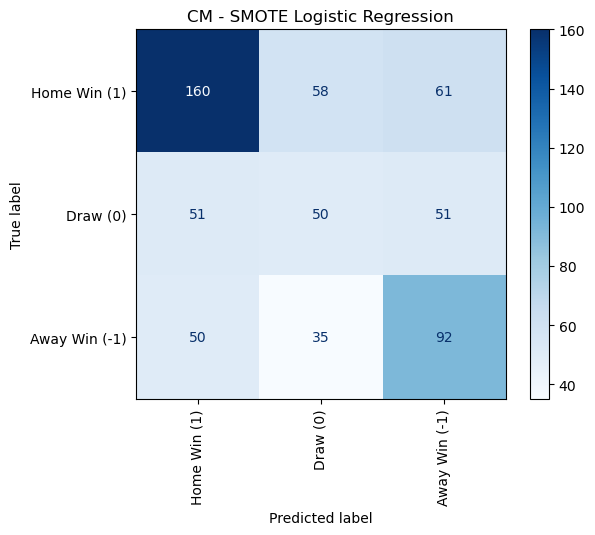

In [346]:
# SMOTE - minority class oversampling

from imblearn.over_sampling import SMOTE

# Step 1: Split data into features (X) and target (y)
X = df.drop('Result', axis=1)
y = df['Result']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Apply SMOTE to the training data
smote = SMOTE(random_state=42) # instantiate SMOTE object
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check the new class distribution
print("Class distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

# Step 3: Train Logistic Regression
logistic_model_balanced = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
logistic_model_balanced.fit(X_train_balanced, y_train_balanced)

# Step 4: Evaluate the model
y_pred_balanced = logistic_model_balanced.predict(X_test)

# Accuracy and classification report
print("SMOTE Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, y_pred_balanced))
print(classification_report(y_test, y_pred_balanced))

# Confusion matrix
cm_balanced = confusion_matrix(y_test, y_pred_balanced, labels=[1, 0, -1])
disp_balanced = ConfusionMatrixDisplay(confusion_matrix=cm_balanced, display_labels=['Home Win (1)', 'Draw (0)', 'Away Win (-1)'])
disp_balanced.plot(cmap='Blues', xticks_rotation='vertical')
disp_balanced.ax_.set_title("CM - SMOTE Logistic Regression")
plt.show()


#### Resuls of SMOTE

- 51.15% predictions correct (slightly worse than vanilla logistic reg.)
- More or less random chance predicting draws
- Virtually the same with away wins

F1 Score of 0.48 improves on the original of 0.38. This reflects better balance (less home win bias) across all three classes even if overall performance is slightly lower.

The ability to predict draws at chance does not make up for the reduced performance of the home wins not being picked up more.

### Optimization - Hyperparameter tuning

In [347]:
logistic_model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    class_weight='balanced',  # Automatically balances weights
    random_state=42
)
logistic_model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   random_state=42)

In [348]:
# hyperparameter tuning with cross-validation

from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'class_weight': [None, 'balanced']  # Test both balanced and unbalanced
}

grid_search = GridSearchCV(
    LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy'
)
grid_search.fit(X_train, y_train)

# Best parameters and accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated Accuracy:", grid_search.best_score_)



Best Parameters: {'C': 0.01, 'class_weight': None}
Best Cross-Validated Accuracy: 0.5291969816040087


Optimized Logistic Regression:
Accuracy: 0.5213815789473685
              precision    recall  f1-score   support

          -1       0.50      0.49      0.49       177
           0       0.00      0.00      0.00       152
           1       0.53      0.82      0.65       279

    accuracy                           0.52       608
   macro avg       0.34      0.44      0.38       608
weighted avg       0.39      0.52      0.44       608



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


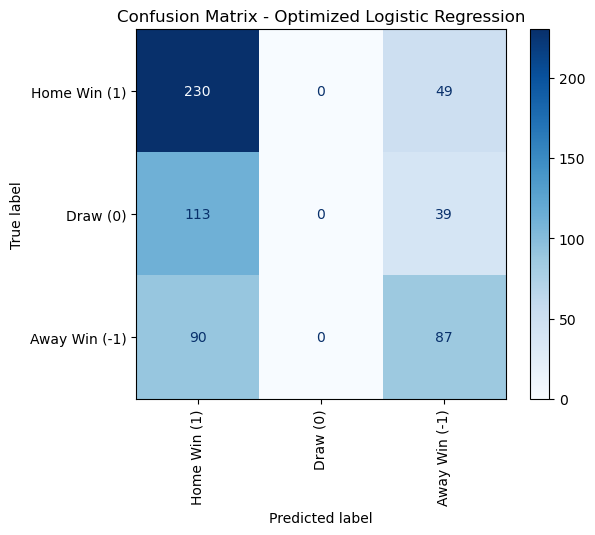

In [349]:
best_logistic_model = grid_search.best_estimator_

# Predictions
y_pred_optimized = best_logistic_model.predict(X_test)

# Accuracy and classification report
print("Optimized Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, y_pred_optimized))
print(classification_report(y_test, y_pred_optimized))

# Confusion matrix
cm_optimized = confusion_matrix(y_test, y_pred_optimized, labels=[1, 0, -1])
disp_optimized = ConfusionMatrixDisplay(confusion_matrix=cm_optimized, display_labels=['Home Win (1)', 'Draw (0)', 'Away Win (-1)'])
disp_optimized.plot(cmap='Blues', xticks_rotation='vertical')
disp_optimized.ax_.set_title("Confusion Matrix - Optimized Logistic Regression")
plt.show()


#### Analysis

We have added about 0.5% performance from this, it's still barely moving and there's no ability to predict draws

### Removing the prior probabilities - are they helping the model or biasing too much?

In [350]:
df.sample(5)

,ppg_season_diff,net_goals_diff,home_pts_last_5,away_pts_last_5,pts_last_5_diff,best_player_diff,p(Home),p(Draw),p(Away),Result
99,0.714812,-0.349484,0.231519,-0.123375,0.286529,-0.334313,1.110223e-16,0.0,-5.551115e-17,-1
2985,-0.828615,-1.397938,-1.194368,-0.690787,-0.402955,-1.521362,1.110223e-16,0.0,-5.551115e-17,-1
1004,0.675902,1.549381,0.231519,-1.541905,1.435669,0.786789,1.110223e-16,0.0,-5.551115e-17,1
2554,1.285491,1.630927,-0.053658,0.160331,-0.173127,1.380314,1.110223e-16,0.0,-5.551115e-17,1
499,3.918396,0.827113,-0.909190,-1.825610,0.746185,0.654895,1.110223e-16,0.0,-5.551115e-17,-1


In [351]:
# make a new dataframe sample without the priors p(home win), p(draw), p(away win)
df_no_prior = df.drop(['p(Home)', 'p(Draw)', 'p(Away)'], axis=1)

In [352]:
df_no_prior.sample(5)

,ppg_season_diff,net_goals_diff,home_pts_last_5,away_pts_last_5,pts_last_5_diff,best_player_diff,Result
1852,0.027403,0.174742,0.516696,0.444037,0.056701,-0.334313,0
2411,-0.102296,-0.139794,-0.338836,-0.407081,0.056701,-1.521362,1
2381,0.455412,-1.106701,-0.338836,-1.825610,1.205841,-1.257574,-1
524,1.454100,2.155154,1.087051,-0.974493,1.665497,2.171680,1
1687,-0.244966,-0.267938,0.801874,0.727743,0.056701,0.457053,0


In [353]:
# scaling

from sklearn.preprocessing import StandardScaler

# Scale only the non-probability features in manual_run_prem
scaler = StandardScaler()
features_to_scale = ['rating_diff', 'net_goals_diff']
df_no_prior[features_to_scale] = scaler.fit_transform(df_no_prior[features_to_scale])

KeyError: "['rating_diff'] not in index"

In [ ]:
# split into X and y
X = df_no_prior.drop('Result', axis=1)
y = df_no_prior['Result']

In [ ]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# train the logistic regression model
logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced', random_state=42)
logistic_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   random_state=42)

In [ ]:
# Evaluate the model
y_pred = logistic_model.predict(X_test)
print("Manual Run Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Manual Run Logistic Regression:
Accuracy: 0.49835526315789475
              precision    recall  f1-score   support

          -1       0.45      0.52      0.48       177
           0       0.33      0.30      0.31       152
           1       0.62      0.59      0.61       279

    accuracy                           0.50       608
   macro avg       0.47      0.47      0.47       608
weighted avg       0.50      0.50      0.50       608



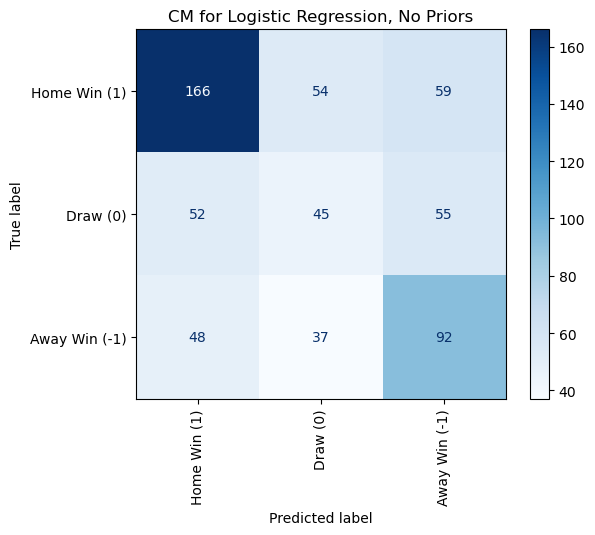

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[1, 0, -1])

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Home Win (1)', 'Draw (0)', 'Away Win (-1)'])

# Plot the confusion matrix
disp.plot(cmap='Blues', xticks_rotation='vertical')
disp.ax_.set_title("CM for Logistic Regression, No Priors")
plt.show()

#### Analysis

- The model is still performing best with home wins but much less so than with the priors
- Draw performance is still effectively just random chance
- mediocre performance on away wins

## First run Optimization - Conclusions

We achieved marginal improvements with a grid search of hyperparameters and cross-validation, about 0.5-1%

The different approaches only seemed to take away some of the bias of home wins and instead gave the model the ability to predict draws no better than chance. Inclusion of the Bayesian priors was improving the model particularly in the home wins prediction but it 

The initial results seem to have hit a ceiling in the low 50% where a bias towards home wins was driving most of the performance above random chance. This was overcompensating for completely avoiding draw predictions.